# Prototype for analytical model classes

The aim of this worksheet is to experiment and design a set of classes for expressing analytical models for well test interpretation. The general idea is that there should be a parent generic class and a set of derived classes allowing to avoid repeating code.

In this first prototype, I consider only the generic parent class and two daughter classes.

Nov. 7 2019 - P. Renard

Nov. 20 2019 - N. Dutler (noflow, consthead incl. laplace)


In [60]:
import sys
sys.path.append("..")
import openhytest as ht
import mpmath as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


In [61]:
# Read a data set to test ideas
df = pd.read_csv('../data/ths_ds1.txt',header=None,sep=" ",names=['t','s'])
df2 = pd.read_csv('../data/thn_ds1.txt',header=None,sep=" ",names=['t','s'])
df3 = pd.read_csv('../data/thc_ds1.txt',header=None,sep=" ",names=['t','s'])
df4 = pd.read_csv('../data/pca_ds1.txt',header=None,sep="\t",names=['t','s'])


Below is the part where the classes are defined in order to test the concept.

The first thing is to define a generic class AnalyticalModels of analytical models that should contain all the generic functionalities.  Then, we derive two examples of daughter classes: the theis and theis_noflow models. 

The theis_noflow model is wrong (wrong equations and parametrizations and needs to be corrected), but the principle seems to work.

The next steps would be to implement:
- the fit function
- one or a pair of examples with laplace domain solution


In [62]:
def get_logline(df):
    logt = np.log10(df.t).values
    Gt = np.array([logt, np.ones(logt.shape)])
    p = np.linalg.inv(Gt.dot(Gt.T)).dot(Gt).dot(df.s)
    p[1] = 10 ** (-p[1] / p[0])
    return p


class AnalyticalSlugModels():
    def __init__(self, Q=None, r=None, rw=None, rc=None):
        self.Q = Q
        self.r = r
        self.rw = rw
        self.rc = rc
        self.rD = r/rc

    def _dimensionless_time(self, p, t):
        return 0.445268 * t /  p[1] * self.rD ** 2

    def _dimensional_drawdown(self, p, sd):
        return 0.868589 * p[0] * np.float64(sd)

    def _laplace_drawdown(self, td, option='Stehfest'):  # default stehfest
        return list(map(lambda x: mp.invertlaplace(self.dimensionless_laplace, x, method=option, dps=10, degree=16), td))

    def _laplace_drawdown_derivative(self, td, option='Stehfest'):  # default stehfest
        return list(map(
            lambda x: mp.invertlaplace(self.dimensionless_laplace_derivative, x, method=option, dps=10, degree=16), td))

    def __call__(self, t):
        print("Warning - undefined")
        return None
    
    def T(self, p):
        return 0.1832339 * self.Q / p[0]

    def S(self, p):
        return 2.2458394 * self.T(p) * p[1] / self.r ** 2
    
    def Cd(self, p):
        return self.rc ** 2 / 2 / self.rw ** 2 / self.S(p)

    def trial(self, p, df):
        figt = plt.figure()
        ax1 = figt.add_subplot(211)
        ax2 = figt.add_subplot(212)
        ax1.loglog(df.t, list(self.__call__(p, df.t)), df.t, df.s, 'o')
        ax1.set_ylabel('s')
        ax1.grid()
        ax1.minorticks_on()
        ax1.grid(which='major', linestyle='--', linewidth='0.5', color='black')
        ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        ax2.semilogx(df.t, list(self.__call__(p, df.t)), df.t, df.s, 'o')
        ax2.set_ylabel('s')
        ax2.set_xlabel('t')
        ax2.grid()
        ax2.minorticks_on()
        ax2.grid(which='major', linestyle='--', linewidth='0.5', color='black')
        ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
        plt.show()
        print('T = ', self.T(p), 'm2/s')
        print('S = ', self.S(p), '-')
        print('Cd = ', self.Cd(p), '-')

    def fit(self, p, df, option='lm', output='all'):
        t = df.t
        s = df.s

        # costfunction
        def fun(p, t, s):
            return np.array(s) - self.__call__(p, t)

        if option == 'lm':
            # Levenberg-Marquard -- Default
            res_p = least_squares(fun, p, args=(t, s), method='lm', xtol=1e-10, verbose=1)
        elif option == 'trf':
            # Trust Region Reflective algorithm
            res_p = least_squares(fun, p, jac='3-point', args=(t, s), method='trf', verbose=1)
        else:
            raise Exception('Specify your option')

        if output == 'all':  # -- Default
            # define regular points to plot the calculated drawdown
            tc = np.logspace(np.log10(t[0]), np.log10(t[len(t) - 1]), num=len(t), endpoint=True, base=10.0,
                             dtype=np.float64)
            sc = self.__call__(res_p.x, tc)
            mr = np.mean(res_p.fun)
            sr = 2 * np.nanstd(res_p.fun)
            rms = np.sqrt(np.mean(res_p.fun ** 2))
            return res_p.x, tc, sc, mr, sr, rms
        elif output == 'p':
            return res_p.x
        elif output == 'Detailled':
            tc = np.logspace(np.log10(t[0]), np.log10(t[len(t) - 1]), num=len(t), endpoint=True, base=10.0,
                             dtype=np.float64)
            sc = self.__call__(res_p.x, tc)
            mr = np.mean(res_p.fun)
            sr = 2 * np.nanstd(res_p.fun)
            rms = np.sqrt(np.mean(res_p.fun ** 2))
            return res_p, tc, sc, mr, sr, rms
        else:
            raise Exception('The output needs to specified: p or all')


# Derived daughter classes

class CooperBredehoeftPapadopulos(AnalyticalSlugModels):
    """
    CooperBredehoeftPapadopulos
    -----------------------------
    
    :param Q:   pumping rate
    :param r:   distance between the observation well and pumping well
    :param rw:  radius if the well
    :param rc:  radius of the casing
    
    
    """
    def dimensionless(self, td, cD):
        return None

    def dimensionless_logderivative(self, td, Rd):
        return None

    def dimensionless_laplace(self, pd):
        sp = mp.sqrt(pd)
        return mp.besselk(0, self.rD * sp) / (pd * (sp * mp.besselk(1, sp) + self.cd * pd * mp.besselk(0, sp)))

    def dimensionless_laplace_derivative(self, pd):
        sp = mp.sqrt(pd)
        cds= self.cd*sp
        k0 = mp.besselk(0,sp)
        k1 = mp.besselk(1,sp)
        kr0 = mp.besselk(0,sp*self.rD)
        kr1 = mp.besselk(1,sp*self.rD)
        return 0.5*((2*self.cd-1)*kr0*k0+kr1*k1+cds*kr1*k0-cds*kr0*k1)/(mp.power(sp*k1+self.cd*pd*k0, 2))

    def __call__(self, p, t):
        self.cd = self.Cd(p)
        td = self._dimensionless_time(p, t)
        sd = self._laplace_drawdown(td)
        s = self._dimensional_drawdown(p, sd)
        return s

    def guess_params(self, df):
        n = 3*len(df) / 4
        return get_logline(df[df.index > n])

    def RadiusOfInfluence(self, p, t):
        return None

    def plot_typecurve(self, cD=10**np.array([1, 2, 3, 4, 5]), rD = 1):
        self.rD = rD
        td = np.logspace(-1, 3)
        ax = plt.gca()
        for i in range(0, len(cD)):
            self.cd = cD[i]
            sd = list(self._laplace_drawdown(td*cD[i]))
            dd = list(self._laplace_drawdown_derivative(td*cD[i]))
            color = next(ax._get_lines.prop_cycler)['color']
            plt.loglog(td, sd, '-', color=color, label=cD[i])
            plt.loglog(td, dd, '-.', color=color)
        plt.xlabel('$t_D / C_D = 2Tt/r_C**2$')
        plt.ylabel('$s_D = 2*pi*T*s/Q$')
        plt.xlim((1e-1, 1e3))
        plt.ylim((1e-1, 1e1))
        plt.grid('True')
        plt.legend()
        plt.show()

# How to create a type curve

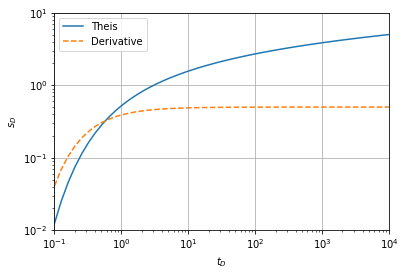

In [9]:
abaque = ht.theis()
abaque.plot_typecurve()


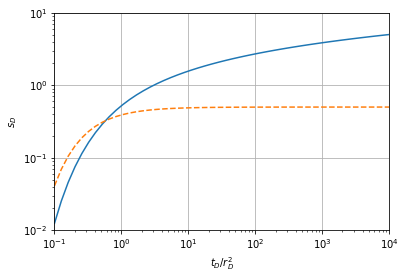

In [7]:
td = np.logspace(-1, 4)
sdn = abaque._laplace_drawdown(td, 'dehoog')
sd = list(sdn)
plt.loglog(td, sd)
#dev = ht.ldiffs(pd.DataFrame({'td':td, 'sd':sd}))
ddn = abaque._laplace_drawdown_derivative(td, 'dehoog')
dd = list(ddn)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.plot(td,dd, '--')
plt.xlim((1e-1, 1e4))
plt.ylim((1e-2, 10))
plt.grid('True')

In [8]:
sd2 = abaque.dimensionless(td)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

4.0733031747911e-12
6.55366209792671e-12
5.22775482183447e-12


In [9]:
dd2 = abaque.dimensionless_logderivative(td)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

5.43991084817064e-13
1.06438262595789e-12
7.6102161202603e-13


# How to adjust a Theis model using guess_params and the fit function

estimated parameter vector: [  1.70038569 341.82452507]


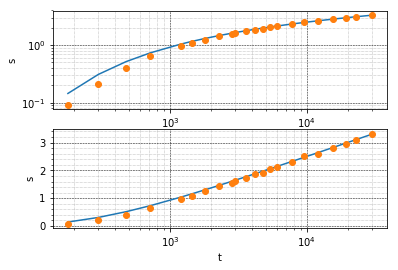

T =  0.0014965736409743885 m2/s
S =  1.838230595036379e-05 -
Ri =  3125.64516579519 m


In [10]:
apaque= ht.theis(Q=1.3888e-2,r=250)
p = apaque.guess_params(df)
print("estimated parameter vector:",p)
apaque.trial(p,df)


In [11]:
p, tc, sc, mr, sr, rms = apaque.fit(p, df, option='trf')

`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 3.2141e-02, final cost 8.4643e-03, first-order optimality 2.15e-10.


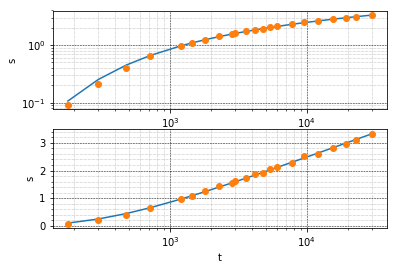

T =  0.00142512353000793 m2/s
S =  2.110457422520216e-05 -
Ri =  2846.6139999696156 m


In [12]:
apaque.trial(p,df)

# Moving to no flow model

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


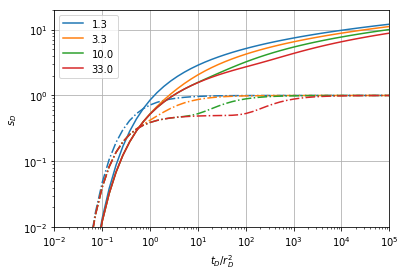

In [14]:
model = ht.theis_noflow(Rd=33)
model.plot_typecurve()

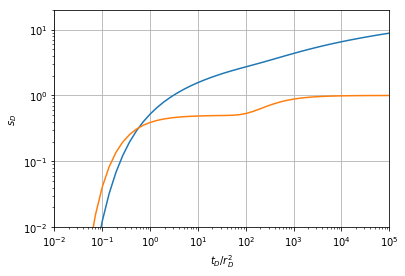

In [15]:
td = np.logspace(-2, 5)
sdn = model._laplace_drawdown(td, 'dehoog')
sd = list(sdn)
plt.loglog(td, sd)
ddn = model._laplace_drawdown_derivative(td, 'dehoog')
dd = list(ddn)
plt.loglog(td, dd)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.xlim((1e-2, 1e5))
plt.ylim((1e-2, 20))
plt.grid('True')

In [16]:
sd2 = model.dimensionless(td, Rd=33)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

5.66010173443643e-12
1.16106363897804e-11
8.10792642961773e-12


In [17]:
dd2 = model.dimensionless_logderivative(td, Rd=33)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

8.71213943253344e-13
1.70786541881051e-12
1.21992409891404e-12


estimated parameter vector: [2.08083534e+00 4.09480142e+02 5.31857688e+04]


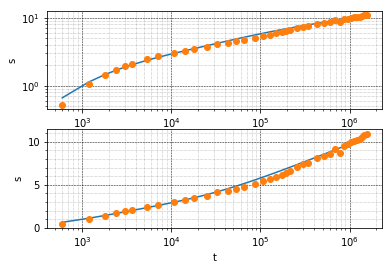

T =  0.0011623637077365074 m2/s
S =  0.0026723515663906582 -
Ri =  227.9351449908511 m


In [19]:
model = ht.theis_noflow(Q=0.0132,r=20)
p = model.guess_params(df2)
print("estimated parameter vector:",p)
model.trial(p,df2)


In [20]:
p, tc, sc, mr, sr, rms = model.fit(p, df2)
p

`ftol` termination condition is satisfied.
Function evaluations 50, initial cost 1.7005e+00, final cost 7.4091e-01, first-order optimality 1.43e-08.


array([2.45693083e+00, 7.00749816e+02, 1.73581927e+05])

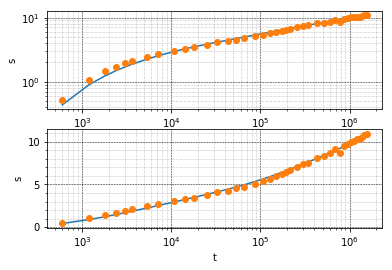

T =  0.000984434504660815 m2/s
S =  0.003873187531444528 -
Ri =  314.77537649835 m


In [21]:
model.trial(p,df2)

# Moving to constant head model

/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


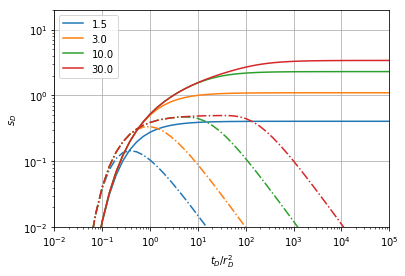

In [22]:
bequer = ht.theis_constanthead(Rd=33)
bequer.plot_typecurve()

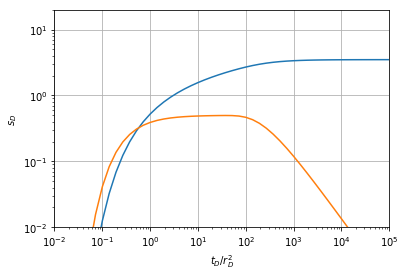

In [23]:
td = np.logspace(-2, 5)
sdn = bequer._laplace_drawdown(td, 'dehoog')
sd = list(sdn)
plt.loglog(td, sd)
ddn = bequer._laplace_drawdown_derivative(td, 'dehoog')
dd = list(ddn)
plt.loglog(td, dd)
plt.xlabel('$t_D / r_D^2$')
plt.ylabel('$s_D$')
plt.xlim((1e-2, 1e5))
plt.ylim((1e-2, 20))
plt.grid('True')

In [24]:
sd2 = bequer.dimensionless(td, Rd=33)
residual = sd-sd2

mr = np.mean(residual) #mean resiudal
print(mr)
sr = 2 * np.std(residual) #standard deviation
print(sr)
rms = np.sqrt(np.mean(residual**2))
print(rms)

3.46500374217285e-12
6.07397390952678e-12
4.60755257123289e-12


In [25]:
dd2 = bequer.dimensionless_logderivative(td, Rd=33)
residual2 = dd-dd2

mr2 = np.mean(residual2) #mean resiudal
print(mr2)
sr2 = 2 * np.std(residual2) #standard deviation
print(sr2)
rms2 = np.sqrt(np.mean(residual2**2))
print(rms2)

2.48201731771575e-13
1.14758501847431e-12
6.25173530558582e-13


estimated parameter vector: [6.22576096e-01 4.76664633e+01 7.62562843e+04]


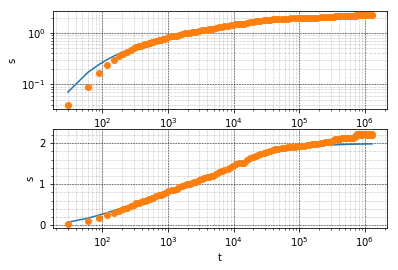

T =  0.008829470055316594 m2/s
S =  0.002363013882213999 -
Ri =  799.9472518866424 m


In [27]:
bequer = ht.theis_constanthead(Q=0.030,r=20)
p = bequer.guess_params(df3)
print("estimated parameter vector:",p)
bequer.trial(p,df3)

In [28]:
p, tc, sc, mr, sr, rms = bequer.fit(p, df3, option='trf')

`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.0579e+00, final cost 9.9037e-02, first-order optimality 6.68e-08.


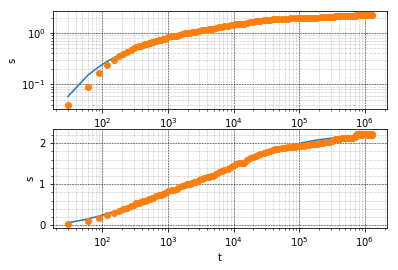

T =  0.008702275268965285 m2/s
S =  0.002656954998754667 -
Ri =  1104.6668793834237 m


In [29]:
bequer.trial(p,df3)

# Cooper-Bredehoeft-Papadopulos model

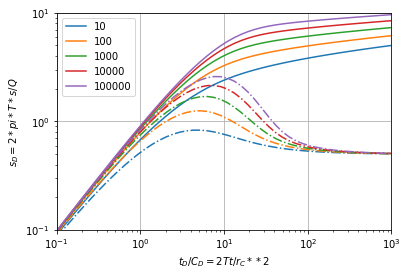

In [15]:
coobredpapa = CooperBredehoeftPapadopulos(r=1, rc=1)
coobredpapa.plot_typecurve()

In [63]:
coobredpapa= CooperBredehoeftPapadopulos(Q=0.0050472, r=3.048, rw=0.6096, rc=0.6096)  
p = coobredpapa.guess_params(df4)
print("estimated parameter vector:",p)


estimated parameter vector: [ 1.12133498 12.07038587]


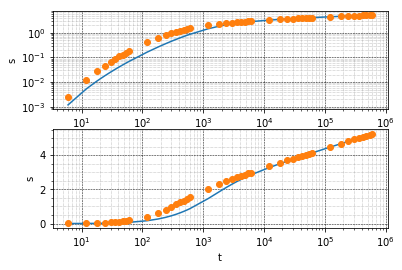

T =  0.0008247474304395393 m2/s
S =  0.0024065278741004052 -
Cd =  207.76821468851975 -


In [64]:
coobredpapa.trial(p,df4)

In [55]:
td = coobredpapa._dimensionless_time(p, df.t)
print(td)


0       166.001818
1       276.669697
2       442.671515
3       664.007273
4      1106.678788
5      1328.014545
6      1660.018182
7      2102.689697
8      2600.695151
9      2766.696969
10     3320.036363
11     3873.375757
12     4426.715151
13     4980.054545
14     5533.393939
15     7193.412120
16     8853.430302
17    11066.787878
18    14386.824241
19    17706.860604
20    21026.896968
21    27666.969694
Name: t, dtype: float64


In [56]:
sd = coobredpapa._laplace_drawdown(td)
print(sd)


[mpf('0.2711241665600910993914403'), mpf('0.4672064020195220712860722'), mpf('0.7334102194928855404167924'), mpf('1.035997653193891964465051'), mpf('1.498713043443001038319648'), mpf('1.677126757381445559287992'), mpf('1.897470578367178132864917'), mpf('2.12658283918834419572062'), mpf('2.323544758603373706231108'), mpf('2.378740922723937234478612'), mpf('2.535066903946356006287064'), mpf('2.659648249686587904349111'), mpf('2.762065381823414396597514'), mpf('2.848435458481385428820249'), mpf('2.922808400630516130372399'), mpf('3.097852082722896173176305'), mpf('3.228108289110664111038921'), mpf('3.361982302977157040751885'), mpf('3.513333605230093431366354'), mpf('3.629620729648804767347604'), mpf('3.72404924709868188917039'), mpf('3.872169732729858803843246')]


In [57]:
s = coobredpapa._dimensional_drawdown(p, np.float64(sd))
s

array([0.26406931, 0.45504933, 0.71432632, 1.00904019, 1.45971537,
       1.63348662, 1.84809692, 2.07124751, 2.26308432, 2.31684424,
       2.4691025 , 2.59044214, 2.6901943 , 2.77431696, 2.84675466,
       3.01724357, 3.14411041, 3.27450092, 3.42191394, 3.53517519,
       3.6271466 , 3.77141288])

In [65]:
p, tc, sc, mr, sr, rms = coobredpapa.fit(p, df4)
p

`ftol` termination condition is satisfied.
Function evaluations 38, initial cost 1.8137e+00, final cost 7.4905e-01, first-order optimality 2.86e-06.


array([0.86750259, 0.84664233])

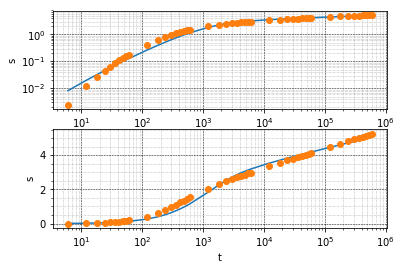

T =  0.0010660695990235623 m2/s
S =  0.00021818973251497086 -
Cd =  2291.5835417035173 -


In [66]:
coobredpapa.trial(p,df4)